# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: Демьянов Иван

Дата выдачи: <span style="color:red">__16 марта 00:00__</span>.

Мягкий дедлайн: <span style="color:red">__30 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `Unet` и `Linknet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [2]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt

from torchvision.models import vgg13
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance
import torchvision.io, os, random, torch.nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats = ['svg', 'pdf']

In [3]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        # your code here
        self.image_paths = os.listdir(images_dir)
        self.targets_paths = os.listdir(target_dir)
        self.image_paths.sort(key=lambda a:int(a[:-4]))
        self.targets_paths.sort(key=lambda a:int(a[:-4]))
        self.images, self.masks, self.len = [], [], 0
        for im_path, mask_path in zip(self.image_paths, self.targets_paths):
            image = Image.open(images_dir + im_path)
            mask = Image.open(target_dir + mask_path)
            for transform in transforms[:-2]:
                image, mask = transform(image, mask)
            tensor_image, tensor_mask = transforms[-2](image), transforms[-2](mask)
            self.images.append(transforms[-1](tensor_image))
            self.masks.append(tensor_mask)
      
    def __len__(self):
        # your code here
        return len(self.images)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        # your code here
        if idx < len(self.images):
            return self.images[idx], self.masks[idx]
        else:
            raise IndexError

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

In [4]:
# your code here
class HorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() > self.p:
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
        return img, mask

class Cut(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() > self.p:
            if random.randint(0, 1):
                size = random.randint(100, 240), random.randint(100, 240)
            else:
                size = random.randint(100, 240)
            new_img = transforms.CenterCrop(size)(img).resize(img.size)
            new_mask = transforms.CenterCrop(size)(mask).resize(mask.size)
            return new_img, new_mask
        return img, mask

class brightness_change(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() > self.p:
            factor = random.random() + 0.5
            return ImageEnhance.Brightness(img).enhance(factor), mask
        return img, mask

class background_change(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() > self.p:
            colors = ['black', 'green', 'yellow', 'blue', 'red', 'white']
            clr = colors[random.randint(0, len(colors)-1)]
            background = Image.new("RGB", (img.size), clr)
            return (Image.composite(img, background, mask), mask)
        return img, mask

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [5]:
DATA_PATH = '/content/drive/MyDrive/people_data/'

train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms=[HorizontalFlip(), Cut(), brightness_change(),
                background_change(), transforms.ToTensor(), 
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=[transforms.ToTensor(), 
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])]
)

Функция для отображения изображения:

In [6]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

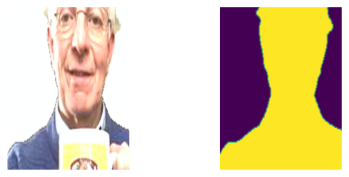

In [ ]:
# your code here
show_idx_image(train_dataset, 3)

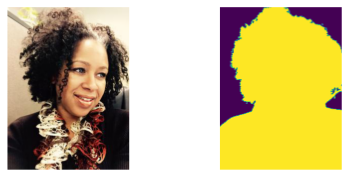

In [ ]:
show_idx_image(train_dataset, 5)

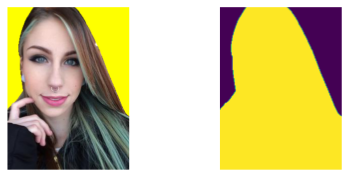

In [ ]:
show_idx_image(train_dataset, 1000)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

In [7]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        # your code here
        dice_loss = 1 - 2 * (true_labels * logits).sum(dim=(1, 2)) / (true_labels + logits + self.eps).sum(dim=(1, 2))

        if self.reduction == 'sum':
            loss_value = torch.sum(dice_loss)
        elif self.reduction == 'mean':
            loss_value = torch.mean(dice_loss)
        elif self.reduction is None:
            loss_value = dice_loss
            
        return loss_value

Проверка реализации:

In [9]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать [UNet](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`. Архитектура сети реализована за вас ниже.

Энкодер:

In [10]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[
                    feature_extractor[j]
                    for j in range(i * 5, i * 5 + 4)
                ])
            )

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [11]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [12]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [13]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [14]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [15]:
# metric
def IoU(y_pred, y_true):
    pred = (torch.sigmoid(y_pred) > 0.5).int()
    inter = y_true * pred
    union = torch.sum(y_true + pred - inter)
    inter = torch.sum(inter)
    return inter / union

# model_fit
def train(model, device, train_loader, test_loader, n_epoch, criterion):
    model = model.to(device)
    mean_losses, metric_list = [], []
    for epoch in tqdm(range(n_epoch)):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            predict = model(inputs)
            loss = criterion(predict, labels)
            loss.backward()
            optimizer.step()
        mean_loss, metric = evaluate_net(model, test_loader, criterion,
                                         IoU, device)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epoch, loss.item()))
        mean_losses.append(mean_loss)
        metric_list.append(metric)
    return mean_losses, metric_list

In [ ]:
# params
num_epoch = 10
lr = 1e-5

# model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

In [ ]:
BCE_losses, IoU_scores_BCE = train(model, device, train_data_loader,
                                        test_data_loader, num_epoch, criterion)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2298
Epoch [2/10], Loss: 0.2778
Epoch [3/10], Loss: 0.2962
Epoch [4/10], Loss: 0.1735
Epoch [5/10], Loss: 0.1602
Epoch [6/10], Loss: 0.1367
Epoch [7/10], Loss: 0.0716
Epoch [8/10], Loss: 0.2976
Epoch [9/10], Loss: 0.0625
Epoch [10/10], Loss: 0.1070


In [ ]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_data_loader))
    imgs = imgs.to(device)
    lbls = lbls.to(device)
    predict = model(imgs)

In [26]:
def show_image_and_mask(image_and_mask):

    image_to_show = image_and_mask[0].cpu().transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = image_and_mask[1][0].cpu().numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Стратегия оптимизации - только кросс-энтропия

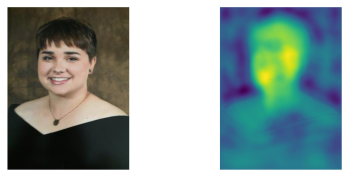

In [ ]:
show_image_and_mask((imgs[1], predict[1]))

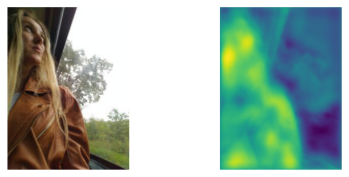

In [ ]:
show_image_and_mask((imgs[5], predict[5]))

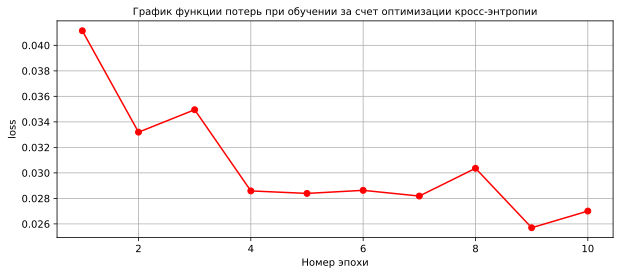

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь при обучении за счет оптимизации кросс-энтропии',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, BCE_losses, linestyle='solid',  marker='o', color='r');
plt.ylabel('loss', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

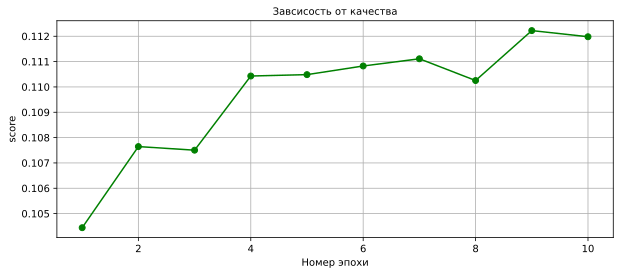

In [ ]:
plt.figure(figsize=(10,4))
plt.title('Завсисость от качества',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, IoU_scores_BCE, linestyle='solid',  marker='o', color='g');
plt.ylabel('score', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

Стратегия оптимизации - только dice loss

In [ ]:
criterion = DiceLoss(reduction='mean')
Dice_losses, IoU_scores_Dice = train(model, device, train_data_loader,
                                        test_data_loader, num_epoch, criterion)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0608
Epoch [2/10], Loss: 0.0768
Epoch [3/10], Loss: 0.0634
Epoch [4/10], Loss: 0.0990
Epoch [5/10], Loss: 0.0320
Epoch [6/10], Loss: 0.1391
Epoch [7/10], Loss: 0.1306
Epoch [8/10], Loss: 0.1195
Epoch [9/10], Loss: 0.1526
Epoch [10/10], Loss: 0.0910


In [ ]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_data_loader))
    imgs = imgs.to(device)
    lbls = lbls.to(device)
    predict = model(imgs)

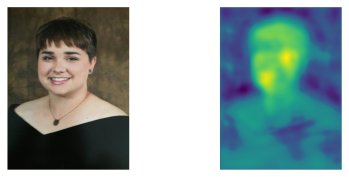

In [ ]:
show_image_and_mask((imgs[1], predict[1]))

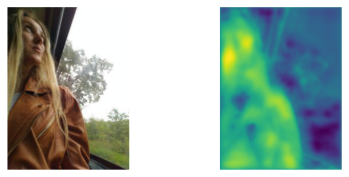

In [ ]:
show_image_and_mask((imgs[5], predict[5]))

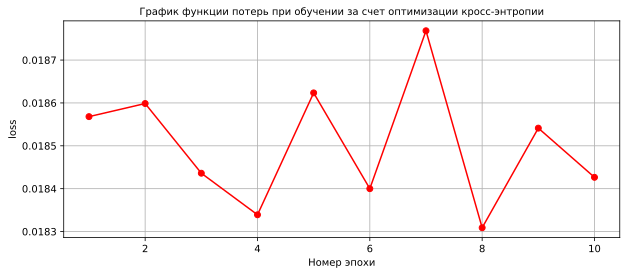

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь при обучении за счет оптимизации кросс-энтропии',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, Dice_losses, linestyle='solid',  marker='o', color='r');
plt.ylabel('loss', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

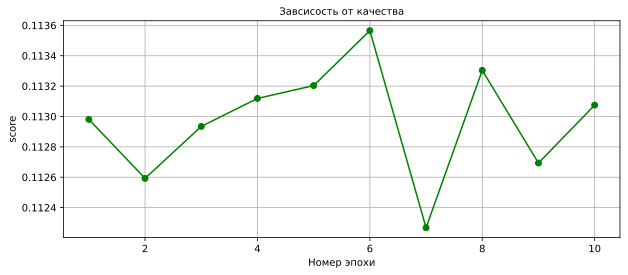

In [ ]:
plt.figure(figsize=(10,4))
plt.title('Завсисость от качества',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, IoU_scores_Dice, linestyle='solid',  marker='o', color='g');
plt.ylabel('score', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

Стратегия оптимизации - сумма двух лоссов с равными весами

In [18]:
class Mix(nn.Module):
    def __init__(self, weights, eps=1e-7, reduction=None, with_logits=True):
      super().__init__()
      self.DiceLoss = DiceLoss(eps=eps, reduction=reduction, 
                               with_logits=with_logits)
      self.BCE = torch.nn.BCEWithLogitsLoss()
      self.w = weights

    def forward(self, logits, true_labels):
      return (self.w[0]*self.DiceLoss.forward(logits, true_labels) +
              self.w[1]*self.BCE.forward(logits, true_labels))

In [ ]:
criterion = Mix([0.5, 0.5], reduction='mean')
mix_losses, IoU_scores_mix = train(model, device, train_data_loader,
                                        test_data_loader, num_epoch, criterion)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2376
Epoch [2/10], Loss: 0.2157
Epoch [3/10], Loss: 0.0784
Epoch [4/10], Loss: 0.1111
Epoch [5/10], Loss: 0.0655
Epoch [6/10], Loss: 0.2048
Epoch [7/10], Loss: 0.2857
Epoch [8/10], Loss: 0.1175
Epoch [9/10], Loss: 0.0731
Epoch [10/10], Loss: 0.0606


In [ ]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_data_loader))
    imgs = imgs.to(device)
    lbls = lbls.to(device)
    predict = model(imgs)

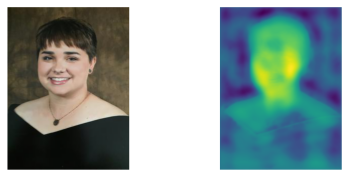

In [ ]:
show_image_and_mask((imgs[1], predict[1]))

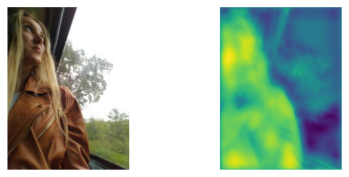

In [ ]:
show_image_and_mask((imgs[5], predict[5]))

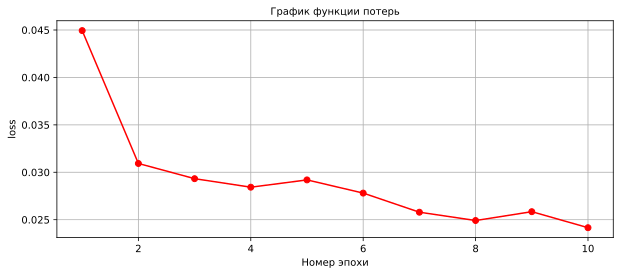

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, mix_losses, linestyle='solid',  marker='o', color='r');
plt.ylabel('loss', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

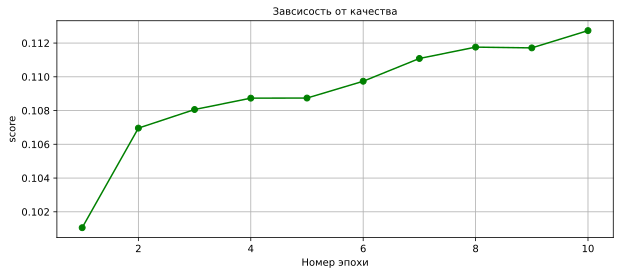

In [ ]:
plt.figure(figsize=(10,4))
plt.title('Завсисость от качества',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, IoU_scores_mix, linestyle='solid',  marker='o', color='g');
plt.ylabel('score', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

по итогам экспериментов с сетью Unet все модели имеют неплохой результат в плане демонстрации сегментированных изображений. В ходе анализа графиков модель, при обучении которой оптимизировалась сумма двух лоссов с равными весами, имеет лучшую сходимотсь.

## LinkNet (2 балла)

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [16]:
class LinkNetDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(x + left))
        x = self.relu(self.conv2(x))
        return x

class LinkNetDecoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', LinkNetDecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = LinkNetDecoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

Стратегия оптимизации - только кросс-энтропия

In [ ]:
model = LinkNet()
criterion = torch.nn.BCEWithLogitsLoss()
Link_BCE_loss, Link_IoU_score = train(model, device, train_data_loader,
                                        test_data_loader, num_epoch, criterion)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.7101
Epoch [2/10], Loss: 0.7079
Epoch [3/10], Loss: 0.7101
Epoch [4/10], Loss: 0.7212
Epoch [5/10], Loss: 0.7004
Epoch [6/10], Loss: 0.6972
Epoch [7/10], Loss: 0.7223
Epoch [8/10], Loss: 0.7157
Epoch [9/10], Loss: 0.7060
Epoch [10/10], Loss: 0.7153


In [ ]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_data_loader))
    imgs = imgs.to(device)
    lbls = lbls.to(device)
    predict = model(imgs)

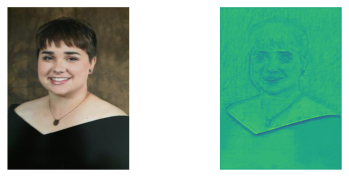

In [ ]:
show_image_and_mask((imgs[1], predict[1]))

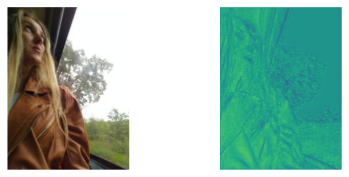

In [ ]:
show_image_and_mask((imgs[5], predict[5]))

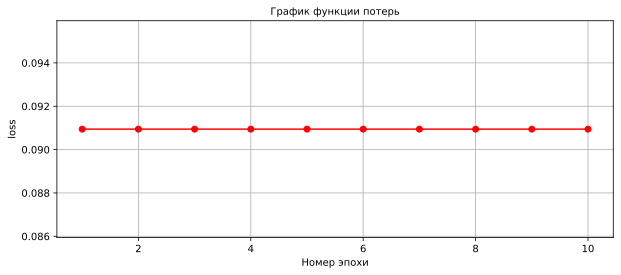

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, Link_BCE_loss, linestyle='solid',  marker='o', color='r');
plt.ylabel('loss', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

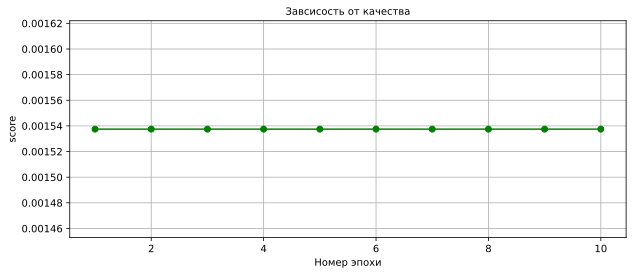

In [ ]:
plt.figure(figsize=(10,4))
plt.title('Завсисость от качества',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, Link_IoU_score, linestyle='solid',  marker='o', color='g');
plt.ylabel('score', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

Стратегия оптимизации - только dice loss

In [ ]:
model = LinkNet()
criterion = DiceLoss(reduction='mean')
Link_BCE_loss, Link_IoU_score = train(model, device, train_data_loader,
                                        test_data_loader, num_epoch, criterion)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.5039
Epoch [2/10], Loss: 0.5246
Epoch [3/10], Loss: 0.4505
Epoch [4/10], Loss: 0.4800
Epoch [5/10], Loss: 0.4812
Epoch [6/10], Loss: 0.4605
Epoch [7/10], Loss: 0.4702
Epoch [8/10], Loss: 0.4295
Epoch [9/10], Loss: 0.4423
Epoch [10/10], Loss: 0.4968


In [ ]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_data_loader))
    imgs = imgs.to(device)
    lbls = lbls.to(device)
    predict = model(imgs)

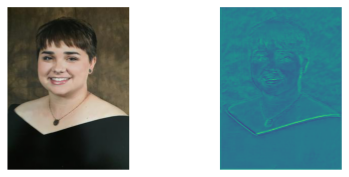

In [ ]:
show_image_and_mask((imgs[1], predict[1]))

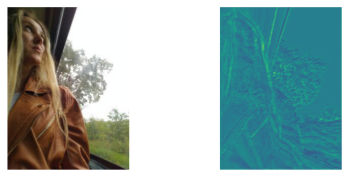

In [ ]:
show_image_and_mask((imgs[5], predict[5]))

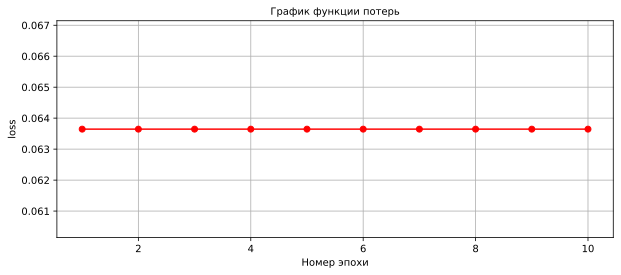

In [ ]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, Link_BCE_loss, linestyle='solid',  marker='o', color='r');
plt.ylabel('loss', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

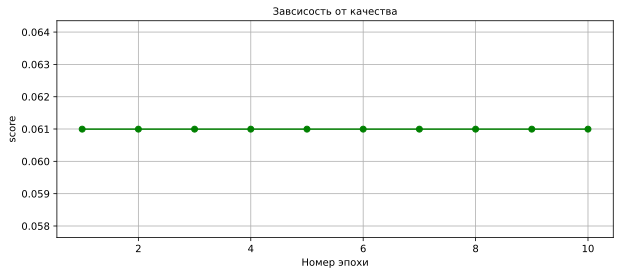

In [ ]:
plt.figure(figsize=(10,4))
plt.title('Завсисость от качества',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, Link_IoU_score, linestyle='solid',  marker='o', color='g');
plt.ylabel('score', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

Стратегия оптимизации - сумма двух лоссов с равными весами

In [22]:
num_epoch = 10
lr = 1e-5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=lr)
model = LinkNet()
criterion = Mix([0.5, 0.5], reduction='mean')
Link_mix_losses, Link_IoU_scores_mix = train(model, device, train_data_loader,
                                        test_data_loader, num_epoch, criterion)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.6486
Epoch [2/10], Loss: 0.5675
Epoch [3/10], Loss: 0.5982
Epoch [4/10], Loss: 0.5671
Epoch [5/10], Loss: 0.5611
Epoch [6/10], Loss: 0.5922
Epoch [7/10], Loss: 0.5669
Epoch [8/10], Loss: 0.4837
Epoch [9/10], Loss: 0.5760
Epoch [10/10], Loss: 0.5699


In [28]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_data_loader))
    imgs = imgs.to(device)
    lbls = lbls.to(device)
    predict = model(imgs)

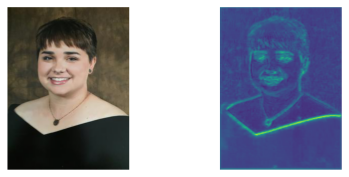

In [29]:
show_image_and_mask((imgs[1], predict[1]))

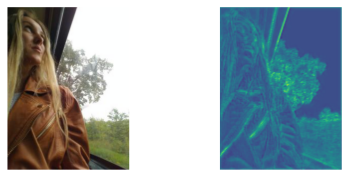

In [31]:
show_image_and_mask((imgs[5], predict[5]))

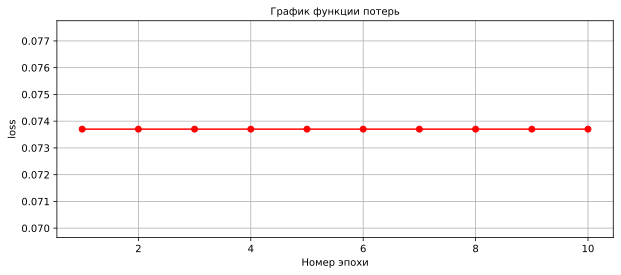

In [32]:
plt.figure(figsize=(10,4))
plt.title('График функции потерь',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, Link_mix_losses, linestyle='solid',  marker='o', color='r');
plt.ylabel('loss', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

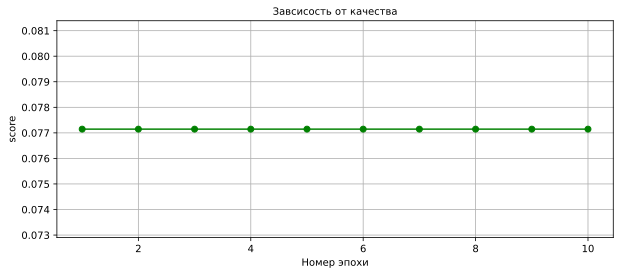

In [33]:
plt.figure(figsize=(10,4))
plt.title('Завсисость от качества',fontsize=10)
plt.grid(True)

n_ep = [i for i in range(1, 11)]
plt.plot(n_ep, Link_IoU_scores_mix, linestyle='solid',  marker='o', color='g');
plt.ylabel('score', fontsize=10)
plt.xlabel('Номер эпохи', fontsize=10);

  По итогам экспериментов чуть лучше себя показала последняя модель, однако вцелом сеть LinkNet гораздо хуже справилась с поставленной задачей, нежели чем Unet. Причиной этому может быть неудачная инициализация начальных параметров для LinkNet или же особенности ее архитектуры.

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

Входные данные должны быть локально связанными между собой и принимать ограниченное множество значений(к примеру, яркость пикселя принимает значения из диапазона [0, 255]). Использование сверток в случае выполнения этих предположений позволяет гибко преобразовывать входные данные, а также способствует увеличению разнообразия архитектур нейронных сетей. Предположения могут не выполняться, если получены некачественные данные (к примеру, плохо измеренная яркость пикселей или изображение в целом плохое для обучения).

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

1. Поскольку функция активации применяется поэлементно и не влияет на размерность выходного пространства для полносвязанного слоя, то размерность составит ${1000\times 1}$. Сверточный слой с размером 3 и паддингом 1 не меняет выходное пространство, с учетом карт признаков получаем, что оно имеет размерность ${10\times 100}$.
2. Обучаемые параметры полносвязного слоя содержит матрица ${W}$, следовательно их 100000. В сверточном слое для каждой карты имеется 3 параметра, следовательно всего их 30.
3. Для вычисления одной координаты вектора выходного пространства потребуется 100 операций умножения и 99 операций сложения, а также столько операций, сколько содержится в функции активации. Итого, число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток) для полносвязного слоя составляет (199 + кол-во операций в $\sigma(\cdot))$ * 1000. В сверточном слое в результате применения паддинга будет 1002 элемента, стало быть имеет место 1000 сверточных преобразований, каждое из которых содержит в себе 3 операции умножения и 2 операции сложения, следовательно в сверточном слое при проходе вперед будет выполнено 5000 операций.

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).